# RL Simulation
Purpose of this simulation is to generate subject data for a volatile learning task. 

# Load packages

In [2]:
import os, sys, glob, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from tqdm import tqdm # progress bar

# Define simulation functions

## Learning model
The learning model used to generate choices is a simple Rescorla-Wagner (Rescorla & Wagner, 1972) model. 

$$ Q(action, trial) = Q(action, trial - 1) + \alpha*prediction_{error}$$

$$ prediction_error = r(trial-1) - Q(action, trial - 1)$$

$$ 0 <= \alpha <= 1 $$

## Softmax

In [3]:
def softmax(q_values, beta):
    # Inputs:
    #       q_values: value of different actions, often just 2
    #       beta: inverse temperature, also known as exploitation parameter
    # Outputs:
    #       choice_probs: model's predicted probability of actions

    # Numerator represents value of utility of single choice
    numerator = np.exp(np.multiply(q_values, beta))

    # Denominator represents sum of total value of utilities
    denominator = np.sum(np.exp(np.multiply(q_values, beta)))
    
    # Outputs
    choice_probs = numerator / denominator
        
    return choice_probs
softmax(np.zeros(2), beta = .1)

array([0.5, 0.5])

## Simulation
`task_parameters` generates the experiment data that an agent will receive. 

In [29]:
def task_parameters(volatility = 'low'): 
    
    # Generate dataframe to store simulated results
    sim_data = pd.DataFrame(columns = ['volatility', 'block', 'block_trial', 'exp_trial', 
                                       'prob_reward_left', 'prob_reward_right', 'reward_left', 'reward_right'])
    
    # Trial sequence
    block_seq = [[17, 15, 19, 18, 15, 17, 19, 15], # high volatility
                [35, 30, 35, 35]] # low volatility
    reward_probs_left = [.7, .3] 
    reward_probs_right = [.3, .7] 

    if volatility == 'low':
        task_blocks = block_seq[1]
        block_prob_reward_left = np.array(reward_probs_left*(np.int(len(task_blocks)/2)))
        block_prob_reward_right = np.array(reward_probs_right*(np.int(len(task_blocks)/2)))
    else: 
        task_blocks = block_seq[0]
        block_prob_reward_left = np.array(reward_probs_left*(np.int(len(task_blocks)/2)))
        block_prob_reward_right = np.array(reward_probs_right*(np.int(len(task_blocks)/2)))

    # generate trials
    trial = 0
    for block in range(len(task_blocks)): 
        block_trial = 0
        # Loop through trials of the block
        for block_trial in range(task_blocks[block]):
            trial += 1
            block_trial += 1
            
            # Generate reward for both choices
            prob_reward_left = block_prob_reward_left[block] # pulls correct probability for left
            prob_reward_right = block_prob_reward_right[block] # pulls correct probability for right
            
            # Left choice
            if np.random.rand() <= prob_reward_left:
                reward_left = 1
            else: 
                reward_left = 0
                
            # Right choice
            if np.random.rand() <= prob_reward_right:
                reward_right = 1
            else: 
                reward_right = 0
                
            # Store results
            trial_data = pd.DataFrame([[volatility, block+1, block_trial, trial, 
                                        prob_reward_left, prob_reward_right, reward_left, reward_right]], 
                                     columns = ['volatility', 'block', 'block_trial', 'exp_trial', 
                                       'prob_reward_left', 'prob_reward_right', 'reward_left', 'reward_right'])
            sim_data = sim_data.append(trial_data).reset_index(drop=True)
            
    return sim_data
sim_data = task_parameters(volatility = 'low')
sim_data.head(5)

,volatility,block,block_trial,exp_trial,prob_reward_left,prob_reward_right,reward_left,reward_right
0,low,1,1,1,0.7,0.3,1,1
1,low,1,2,2,0.7,0.3,0,0
2,low,1,3,3,0.7,0.3,1,1
3,low,1,4,4,0.7,0.3,1,0
4,low,1,5,5,0.7,0.3,1,0


## Task plot


(-0.1, 1.1)

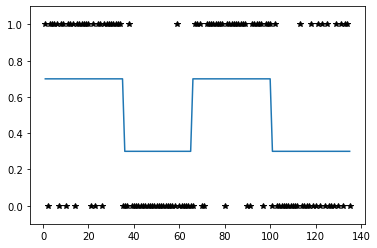

In [30]:
plt.plot('exp_trial', 'prob_reward_left', data = sim_data)
plt.plot('exp_trial', 'reward_left', 'k*', data = sim_data)
plt.ylim(-.1, 1.1)

In [51]:
def rl_simulate(params, data): 
    
    # Initialize parameters
    # two alphas? (positive vs negative pes), stickiness? (likelihood of just repeating past action)
    # two-step modeling
    alpha = params[0] # learning param
    beta = params[1] # exploitation param
    q_values = [.5, .5] # q-values for left and right choices start at .5
    log_likelihood = 0.
    
    # Loop over rows in data
    for index, row in data.iterrows(): # loop over rows, slow but easy to understand and index
        
        # Compute probability of chosing left or right
        choice_probs = softmax(q_values, beta) 
        
        # Make choice weighted by probabilities
        # probabilities given by left, right
        if np.random.rand() <= choice_probs[0]:
            choice = 'left'
            choice_num = 0
        else:
            choice = 'right'
            choice_num = 1

        # Update likelihood
        log_likelihood += np.log(choice_probs[choice_num]) # index based on choice 
                    
        # Store (keep above update)      
        data.at[index, 'choice'] = choice # useful way to append single values
        data.at[index, 'choice_num'] = choice_num
        data.at[index, 'prob_left'] = choice_probs[0]
        data.at[index, 'prob_right'] = choice_probs[1]
        data.at[index, 'q_left'] = q_values[0]
        data.at[index, 'q_right'] = q_values[1]
        
        # Update q_values (to be used on next trial)
        # All the magic happens here
        if choice == 'left':
            pe = row['reward_left'] - q_values[choice_num] # compute pe = reward - q_value['choice']
            q_values[choice_num] = q_values[choice_num] + alpha*pe # update value
        else:
            pe = row['reward_right'] - q_values[choice_num] # compute pe
            q_values[choice_num] = q_values[choice_num] + alpha*pe # update value
                
    # Add final information
    data['alpha'] = alpha
    data['beta'] = beta
    
    return data
        
sim_data2 = rl_simulate(params = [.5, 5], data = sim_data)
sim_data2

,volatility,block,block_trial,exp_trial,prob_reward_left,prob_reward_right,reward_left,reward_right,choice,choice_num,prob_left,prob_right,q_left,q_right,alpha,beta,choice_smoothed
0,low,1,1,1,0.7,0.3,1,1,right,1.0,0.500000,0.500000,0.500000,0.500000,0.5,5,NaN
1,low,1,2,2,0.7,0.3,0,0,left,0.0,0.222700,0.777300,0.500000,0.750000,0.5,5,NaN
2,low,1,3,3,0.7,0.3,1,1,right,1.0,0.075858,0.924142,0.250000,0.750000,0.5,5,NaN
3,low,1,4,4,0.7,0.3,1,0,right,1.0,0.042088,0.957912,0.250000,0.875000,0.5,5,NaN
4,low,1,5,5,0.7,0.3,1,0,left,0.0,0.281406,0.718594,0.250000,0.437500,0.5,5,NaN
5,low,1,6,6,0.7,0.3,1,1,right,1.0,0.718594,0.281406,0.625000,0.437500,0.5,5,0.166667
6,low,1,7,7,0.7,0.3,0,0,left,0.0,0.384912,0.615088,0.625000,0.718750,0.5,5,0.166667
7,low,1,8,8,0.7,0.3,1,0,right,1.0,0.115961,0.884039,0.312500,0.718750,0.5,5,0.333333
8,low,1,9,9,0.7,0.3,1,0,right,1.0,0.441673,0.558327,0.312500,0.359375,0.5,5,0.333333
9,low,1,10,10,0.7,0.3,0,1,left,0.0,0.660172,0.339828,0.312500,0.179688,0.5,5,0.500000


# Plot

## Plot 1 - Simulated Behavior
This plot simply shows the simulated behavior for choosing the left armed bandit (0) or right armed bandit (1) 
- the solid black line shows the 'true' probability of being rewarded for picking the right armed bandit. This was fixed by the experimental design
- the black asteriks indicate the simulated actual choices, where 1 = right and 0 = left
- the dashed red line is a 6 trial moving average

In [52]:
reward_sum = []

for index, row in sim_data2.iterrows(): # loop over rows, slow but easy to understand and index
    
    if row['choice'] == 'left':
        reward_trial = row['reward_left']
        reward_sum.append(reward_trial)
    else:
        reward_trial = row['reward_right']
        reward_sum.append(reward_trial)
        
np.sum(reward_sum)/135

0.6148148148148148

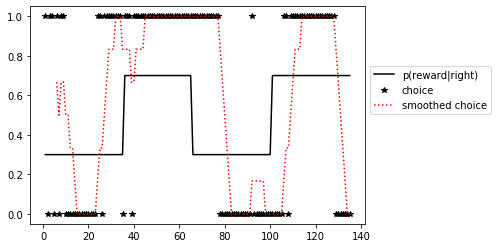

In [53]:
# Moving average of 6 trials
sim_data2['choice_smoothed'] = sim_data2['choice_num'].rolling(window = 6).mean()

# Plot
plt.plot('exp_trial', 'prob_reward_right', 'k', data = sim_data2) # black solid line
plt.plot('exp_trial', 'choice_num', 'k*', data = sim_data2) # black stars
plt.plot('exp_trial', 'choice_smoothed', 'r:', data = sim_data2) # dashed red
plt.legend(['p(reward|right)', 'choice', 'smoothed choice'], bbox_to_anchor = (1, .75))
plt.show()

## Plot 2 - Simulated Behavior /w Model
The plot shows the simulated behavior and also includes the model predictions for specified alpha and beta

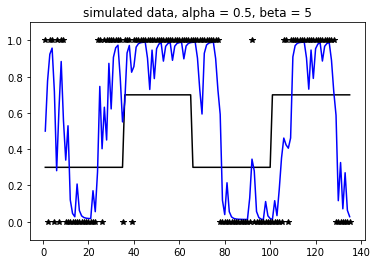

In [55]:
plt.plot('exp_trial', 'prob_reward_right', 'k', data = sim_data2)
plt.plot('exp_trial', 'prob_right', '-b', data = sim_data2)
#plt.plot('exp_trial', 'q_right', ':', data = sim_data2)
#plt.plot('exp_trial', 'q_left', ':', data = sim_data2)
plt.plot('exp_trial', 'choice_num', 'k*', data = sim_data2)
#plt.legend(['p(reward|right)', 'p(choose right)', 'value right', 'value left', 'choice'], 
#           bbox_to_anchor = (1, .75))
plt.title('simulated data, alpha = ' + str(sim_data2['alpha'][0]) + ', beta = ' + str(sim_data2['beta'][0]))
plt.ylim(-.1, 1.1)
plt.show()

# Homework
Fit simulated behavior of agent with alpha = .5, beta = 5 (you may need to average over multiple simulated agents to see if you can capture the average alpha and average beta) 

Data/RL_data_Joey.csv is my actual data, low volatility